In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

play_data = pd.read_csv('./data/plays.csv')
pff_data = pd.read_csv('./data/PFFScoutingData.csv')

discard_results = ['Non-Special Teams Result']#,'Blocked Punt']
punt_plays = play_data[(play_data['specialTeamsPlayType']=='Punt')&(~play_data['specialTeamsResult'].isin(discard_results))]
pff_punt = pff_data.merge(punt_plays[['gameId','playId']],on=['gameId','playId'],how='inner')

fb_land = pd.read_csv('./ReducedData/fb_land.csv')

In [2]:
# 2018 Football Tracking Data
tracking_game = pd.read_csv('./data/tracking2018.csv', chunksize=10**5)
football_tracking = pd.concat((x.query("displayName == 'football'") for x in tracking_game), ignore_index=True)
punt_fbtrack_18 = football_tracking.merge(punt_plays[['gameId','playId']],on=['gameId','playId'])
punt_fbtrack_18['time'] = pd.to_datetime(punt_fbtrack_18['time'])

# 2019 Football Tracking Data
tracking_game = pd.read_csv('./data/tracking2019.csv', chunksize=10**5)
football_tracking = pd.concat((x.query("displayName == 'football'") for x in tracking_game), ignore_index=True)
punt_fbtrack_19 = football_tracking.merge(punt_plays[['gameId','playId']],on=['gameId','playId'])
punt_fbtrack_19['time'] = pd.to_datetime(punt_fbtrack_19['time'])

# 2020 Football Tracking Data
tracking_game = pd.read_csv('./data/tracking2020.csv', chunksize=10**5)
football_tracking = pd.concat((x.query("displayName == 'football'") for x in tracking_game), ignore_index=True)
punt_fbtrack_20 = football_tracking.merge(punt_plays[['gameId','playId']],on=['gameId','playId'])
punt_fbtrack_20['time'] = pd.to_datetime(punt_fbtrack_20['time'])

# Combine all above tracking data
punt_fbtrack = pd.concat([punt_fbtrack_18,punt_fbtrack_19,punt_fbtrack_20]) \
                .sort_values(by=['gameId','playId','frameId']) \
                .drop(columns=['o','dir','nflId','displayName','jerseyNumber','position','team']) \
                .reset_index(drop=True)

# & frameId == 1

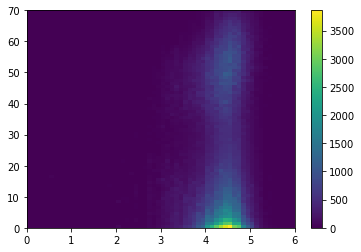

In [3]:
in_bound = fb_land[(fb_land['x']<110)&(fb_land['x']>10)&(fb_land['y']>0)&(fb_land['y']<160/3)]
snap = punt_fbtrack[['gameId','playId','x','y']].rename({'x':'snap_x','y':'snap_y'},axis=1)
distance_in = in_bound.merge(snap)
distance_in['dist_x'] = distance_in['x']-distance_in['snap_x']
distance_in['dist_y'] = distance_in['y']-distance_in['snap_y']
distance_in['dist'] = np.sqrt(distance_in['dist_x']**2 + distance_in['dist_y']**2)

plt.hist2d(distance_in['hangTime'],distance_in['dist'],bins=[np.linspace(0,6,61),np.linspace(0,70,71)])
plt.colorbar()
plt.show()

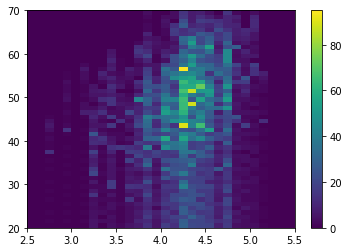

In [4]:
out_bound = fb_land[(fb_land['y']<0)|(fb_land['y']>160/3)]
distance_out = out_bound.merge(snap)
distance_out['dist_x'] = distance_out['x']-distance_out['snap_x']
distance_out['dist_y'] = distance_out['y']-distance_out['snap_y']
distance_out['dist'] = np.sqrt(distance_out['dist_x']**2 + distance_out['dist_y']**2)

plt.hist2d(distance_out['hangTime'],np.abs(distance_out['dist']),bins=[np.linspace(2.5,5.5,31),np.linspace(20,70,51)])
plt.colorbar()
plt.show()

In [5]:
fb_land_ext = fb_land.merge(punt_plays[['gameId','playId','specialTeamsResult']]) \
                .merge(pff_punt[['gameId','playId','kickContactType']])

fb_land_ext['kickContactType'].value_counts(dropna=False)

CC      3742
BF      1059
BB       309
OOB      283
CFFG     150
MBDR     145
DEZ       66
KTC       31
BC        23
KTB       22
ICC       16
KTF       12
MBC        9
BOG        5
NaN        2
Name: kickContactType, dtype: int64

In [6]:
ttt = in_bound.merge(punt_plays[['gameId','playId','specialTeamsResult']]) \
                .merge(pff_punt[['gameId','playId','kickContactType']]).merge(punt_fbtrack[['gameId','playId','frameId','event']])

ttt#[((ttt['kickContactType'].isna())|(ttt['kickContactType']=='OOB'))&(ttt['event']!='out_of_bounds')]['event'].value_counts()

,gameId,playId,x,y,hangTime,frameId,playDirection,specialTeamsResult,kickContactType,event
0,2018090600,366,72.61,39.18,4.46,78,right,Return,CC,punt_received
1,2018090600,872,96.45,39.01,4.35,76,right,Touchback,BF,None
2,2018090600,973,69.30,48.70,4.98,84,right,Fair Catch,CC,None
3,2018090600,1850,20.49,43.54,4.53,78,left,Downed,BB,None
4,2018090600,1989,92.21,35.84,4.62,81,right,Return,CC,None
...,...,...,...,...,...,...,...,...,...,...
5520,2021010315,1359,45.37,2.87,4.50,77,left,Return,CC,punt_received
5521,2021010315,1479,92.58,11.68,4.80,81,right,Return,CC,punt_received
5522,2021010315,2235,78.69,27.04,3.36,67,right,Return,CC,None
5523,2021010315,2497,88.41,32.99,4.69,80,right,Return,CC,punt_received


Categorize each punt based on whether the receiving team catches (or attempts to catch) the punt, or whether they allow the ball to bounce.

In [7]:
# All punts of a particular contact type are bounces or catches
contact_to_land = {
    'BB':'Bounce',
    'BC':'Catch',
    'BF':'Bounce',
    'BOG':'Bounce',
    'CC':'Catch',
    'CFFG':'Bounce',
    'DEZ':'Bounce',
    'KTB':'Bounce',
    'KTC':'Bounce',
    'KTF':'Bounce',
}

# The remaining punts (ICC, MBC, MBDR, OOB, NaN) need to be looked at individually.
# OOB with the event as out_of_bounds should be listed as out_plays, so we must remove.
# For OOB and NaN events, the events are all filled and correspond to the following catch/bounce result:
event_to_land = {
    'kick_received':'Catch',
    'punt_received':'Catch',
    'punt_land':'Bounce',
    'fair_catch':'Catch',
    'fumble_defense_recovered':'Catch',
    'punt_muffed':'Catch',
    'fumble':'Catch' # For MBDR event
}

# Look at MBDR punts:
# Only need to look at events labelled 'None'
# The rest are the same as the OOB+NaN events thus can be combined.
event_to_land_MBDR = {
    'punt_received':'Catch',
    'punt_land':'Bounce',
    'fair_catch':'Catch',
    'punt_muffed':'Catch',
    'fumble':'Catch'
}
# For 'None' events, look at [3]:
event_to_land_MBDR_3 = {
    #'punt_received':'Catch',
    #'punt_land':'Bounce',
    'fair_catch':'Catch',
    'kick_received':'Catch',
    #'punt_muffed':'Catch',
    'fumble':'Catch'
}

# Look at MBC punts:
# 2018112504 - 2312 -> 'Catch'
# All others are 'Bounce'

# Look at ICC punts:
# specialTeamsResult = Fair Catch -> 'Catch'
# Remaining events, make event table look at [3]
event_to_land_ICC = {
    'punt_received':'Catch',
    'first_contact':'Catch',
    'punt_muffed':'Catch',
    'punt_received':'Catch',
    'punt_downed':'Bounce',
    'punt_land':'Bounce',
    'fair_catch':'Catch',
    'kick_received':'Catch',
    'fumble':'Catch'
}

In [8]:
def event_table(df, exc_list=[]):
    df_trim = df[(~df['event'].isin(exc_list))&(df['event']!='None')].copy()
    df_trim['event_num'] = df_trim.groupby(['gameId','playId']).apply(lambda x: (x['event']!='').cumsum()) \
                                    .reset_index([0,1],drop=True)
    return pd.pivot_table(df_trim, values='event', index=['gameId','playId'],columns='event_num',aggfunc=lambda x: ''.join(x))

remaining_meta = ttt[ttt['kickContactType'].isin(['ICC','MBC','MBDR'])]
remaining_track = punt_fbtrack.merge(remaining_meta[['gameId','playId']])
remaining_table = event_table(remaining_track,['line_set']).reset_index([0,1]).merge(remaining_meta[['gameId','playId','specialTeamsResult','kickContactType','event']])

In [9]:
ttt['Type'] = ttt['kickContactType'].map(contact_to_land)
ttt['Type'].value_counts(dropna=False)

Catch     3760
Bounce    1567
NaN        198
Name: Type, dtype: int64

In [10]:
len(ttt[((ttt['kickContactType']=='OOB')|(ttt['kickContactType'].isna())|(ttt['kickContactType']=='MBDR'))&(ttt['event']!='None')])

72

In [11]:
ttt_removed = ttt.drop(ttt[((ttt['kickContactType']=='OOB')|(ttt['kickContactType'].isna()))&(ttt['event']=='out_of_bounds')].index)
ttt_removed.loc[ttt_removed['Type'].isna(),'Type'] = ttt_removed[(ttt_removed['kickContactType'].isin(['OOB','MBDR']))|(ttt_removed['kickContactType'].isna())]['event'].map(event_to_land)
ttt_removed['Type'].value_counts(dropna=False)

Catch     3813
Bounce    1575
NaN        126
Name: Type, dtype: int64

In [12]:
len(ttt_removed[ttt_removed['kickContactType']=='MBC'])

9

In [13]:
ttt_removed.loc[ttt_removed['kickContactType']=='MBC','Type'] = 'Bounce'
ttt_removed.loc[(ttt_removed['gameId']==2018112504)&(ttt_removed['playId']==2312),'Type'] = 'Catch'
ttt_removed['Type'].value_counts(dropna=False)

Catch     3814
Bounce    1583
NaN        117
Name: Type, dtype: int64

In [14]:
ttt_removed.loc[(ttt_removed['kickContactType']=='ICC')&(ttt_removed['specialTeamsResult']=='Fair Catch'),'Type'] = 'Catch'
ttt_removed['Type'].value_counts(dropna=False)

Catch     3817
Bounce    1583
NaN        114
Name: Type, dtype: int64

In [15]:
full_event_punts = ttt_removed[ttt_removed['Type'].isna()]
full_event_punts_table = event_table(punt_fbtrack.merge(full_event_punts[['gameId','playId']]),['line_set']).reset_index([0,1]).merge(full_event_punts[['gameId','playId','specialTeamsResult','kickContactType']])
full_event_punts_table['Type_update'] = full_event_punts_table[3].map(event_to_land_ICC)

In [16]:
full_event_punts_table

,gameId,playId,1,2,3,4,5,6,7,8,9,specialTeamsResult,kickContactType,Type_update
0,2018090900,2097,ball_snap,punt,punt_muffed,out_of_bounds,NaN,NaN,NaN,NaN,NaN,Muffed,MBDR,Catch
1,2018090907,4113,ball_snap,punt,punt_muffed,fumble_defense_recovered,fumble_offense_recovered,tackle,NaN,NaN,NaN,Muffed,MBDR,Catch
2,2018091601,2485,ball_snap,punt,punt_received,punt_muffed,fumble,fumble_offense_recovered,touchback,NaN,NaN,Muffed,MBDR,Catch
3,2018092307,2461,ball_snap,punt,punt_received,fumble,fumble_offense_recovered,tackle,NaN,NaN,NaN,Muffed,MBDR,Catch
4,2018092308,569,ball_snap,punt,punt_muffed,punt_received,first_contact,tackle,NaN,NaN,NaN,Muffed,MBDR,Catch
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,2020121900,1506,ball_snap,punt,punt_muffed,punt_received,fumble,fumble_defense_recovered,tackle,NaN,NaN,Muffed,MBDR,Catch
110,2020122010,2634,ball_snap,punt,punt_muffed,punt_received,fumble_defense_recovered,tackle,NaN,NaN,NaN,Muffed,MBDR,Catch
111,2020122710,843,ball_snap,punt,punt_muffed,fumble_defense_recovered,fumble_offense_recovered,touchdown,NaN,NaN,NaN,Muffed,MBDR,Catch
112,2021010300,4075,ball_snap,punt,punt_muffed,fumble_offense_recovered,first_contact,out_of_bounds,NaN,NaN,NaN,Muffed,MBDR,Catch


In [19]:
ttt_removed = ttt_removed.merge(full_event_punts_table[['gameId','playId','Type_update']],how='left')
ttt_removed.loc[ttt_removed['Type'].isna(),'Type'] = ttt_removed['Type_update']
ttt_removed.drop(columns=['Type_update', 'specialTeamsResult','kickContactType','event'],inplace=True)
ttt_removed

,gameId,playId,x,y,hangTime,frameId,playDirection,Type
0,2018090600,366,72.61,39.18,4.46,78,right,Catch
1,2018090600,872,96.45,39.01,4.35,76,right,Bounce
2,2018090600,973,69.30,48.70,4.98,84,right,Catch
3,2018090600,1850,20.49,43.54,4.53,78,left,Bounce
4,2018090600,1989,92.21,35.84,4.62,81,right,Catch
...,...,...,...,...,...,...,...,...
5509,2021010315,1359,45.37,2.87,4.50,77,left,Catch
5510,2021010315,1479,92.58,11.68,4.80,81,right,Catch
5511,2021010315,2235,78.69,27.04,3.36,67,right,Catch
5512,2021010315,2497,88.41,32.99,4.69,80,right,Catch


In [236]:
ttt_removed.to_csv('./ReducedData/BounceCatch.csv', index=False)